<a href="https://colab.research.google.com/github/ny0y/CustomerSupportChatbot/blob/main/ChatbotCustomerService.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Wed Dec  4 08:13:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8              15W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Cell 1: Install Required Packages**

In [ ]:
# Import required libraries
!pip install transformers
!pip install torch
!pip install pandas
!pip install scikit-learn
!pip install tensorflow
!pip install datasets

In [8]:
!pip install tensorflow


In [45]:
!pip install datasets


**Cell 2: Import Libraries**

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datasets import Dataset



**Cell 3: Load Dataset**




In [47]:
#from google.colab import files
#uploaded = files.upload()

dataset_path = '/content/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv'
data = pd.read_csv(dataset_path)

data.head()  # Display first few rows for inspection
# print(data.columns)  # Check the actual column names
# Check the unique intents in the 'intent' column
#print(data['intent'].unique())


,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


**Cell 4: Preprocess Data**

In [48]:

data['intent'] = data['intent'].astype('category').cat.codes

# Split the dataset into training and testing
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['instruction'], data['intent'], test_size=0.2, stratify=data['intent']
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.values
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.values
})



Build the Neural Network

In [50]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['intent'].unique()))

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Optional, if you want to load the best model after training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.556100,0.015480
2,0.016900,0.009570
3,0.002300,0.009920


TrainOutput(global_step=2016, training_loss=0.1441114370679734, metrics={'train_runtime': 496.676, 'train_samples_per_second': 129.845, 'train_steps_per_second': 4.059, 'total_flos': 1027607850782730.0, 'train_loss': 0.1441114370679734, 'epoch': 3.0})

In [52]:
trainer.evaluate()


{'eval_loss': 0.00956954900175333,
 'eval_runtime': 10.2717,
 'eval_samples_per_second': 523.281,
 'eval_steps_per_second': 8.178,
 'epoch': 3.0}

**Build the Neural Network**

**Cell 7: Train the Model**

In [9]:
model.save_pretrained("/content/bert_chatbot_model")
tokenizer.save_pretrained("/content/bert_chatbot_model")


Epoch 1: 100%|██████████| 672/672 [02:09<00:00,  5.20it/s]

	Loss = 0.0507, Accuracy = 0.9946


**Cell 8: Evaluate the Model**

In [10]:
text_input = "How do I change my address"
inputs = tokenizer(text_input, return_tensors='pt', padding=True, truncation=True, max_length=128)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

intent_labels = [
    "cancel_order", "change_order", "change_shipping_address", "check_cancellation_fee",
    "check_invoice", "check_payment_methods", "check_refund_policy", "complaint",
    "contact_customer_service", "contact_human_agent", "create_account", "delete_account",
    "delivery_options", "delivery_period", "edit_account", "get_invoice", "get_refund",
    "newsletter_subscription", "payment_issue", "place_order", "recover_password",
    "registration_problems", "review", "set_up_shipping_address", "switch_account",
    "track_order", "track_refund"
]

predicted_intent = intent_labels[predicted_class]
print(f"Chatbot Response: {predicted_intent}")


Evaluating: 100%|██████████| 168/168 [00:09<00:00, 17.65it/s]

	Test Accuracy: 0.9967


**Cell 9: Save and Load the Model**

In [11]:
# Save the model and tokenizer
model.save_pretrained("/content/bert_chatbot_model")
tokenizer.save_pretrained("/content/bert_chatbot_model")

# Reload the model and tokenizer
model = BertForSequenceClassification.from_pretrained("/content/bert_chatbot_model")
tokenizer = BertTokenizer.from_pretrained("/content/bert_chatbot_model")

**Cell 10: Chatbot Inference**

In [12]:
# Sample input text for inference
text_input = "How i do change my address"

# Tokenize the input text
inputs = tokenizer(text_input, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Move input tensors to the same device as the model (GPU or CPU)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Ensure the model is on the same device
model.to(device)

# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():  # Disable gradients during inference
    outputs = model(**inputs)  # Forward pass through the model
    logits = outputs.logits  # Get the model's raw output (logits)
    predicted_class = torch.argmax(logits, dim=1).item()  # Get the predicted class index

# Debugging: Print the predicted class index and available categories
print(f"Predicted class index: {predicted_class}")

# Get the number of intent classes
num_classes = len(data['intent'].astype('category').cat.categories)
print(f"Number of classes: {num_classes}")

# Define the intent_labels list (make sure this list has the correct number of categories)
intent_labels = [
    "cancel_order", "change_order", "change_shipping_address", "check_cancellation_fee",
    "check_invoice", "check_payment_methods", "check_refund_policy", "complaint",
    "contact_customer_service", "contact_human_agent", "create_account", "delete_account",
    "delivery_options", "delivery_period", "edit_account", "get_invoice", "get_refund",
    "newsletter_subscription", "payment_issue", "place_order", "recover_password",
    "registration_problems", "review", "set_up_shipping_address", "switch_account",
    "track_order", "track_refund"
]

# Ensure the list has the correct number of categories
if len(intent_labels) == num_classes:
    predicted_intent = intent_labels[predicted_class]
    print(f"Chatbot Response: {predicted_intent}")
else:
    print(f"Error: Mismatch between predicted class index and intent labels list size.")


Predicted class index: 2
Number of classes: 27
Chatbot Response: change_shipping_address


**Cell 11 : confusion matrix**

Evaluating: 100%|██████████| 168/168 [00:10<00:00, 16.01it/s]


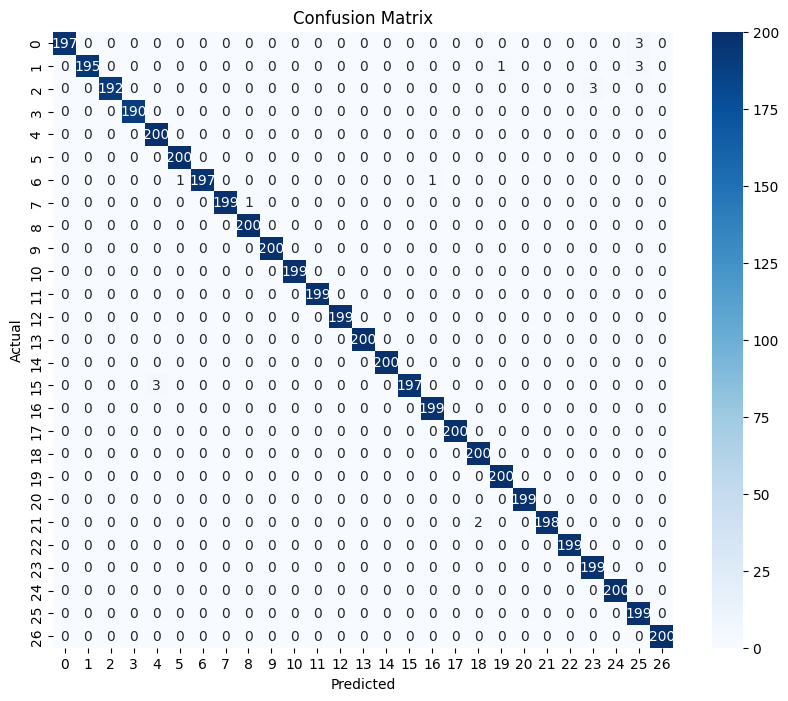

In [13]:
# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data['intent'].astype('category').cat.categories, yticklabels=data['intent'].astype('category').cat.categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Cell 12 : Test the classfication**

In [14]:
# Sample code for user input
while True:
    # Prompt the user for input
    text_input = input("Please enter your message (type 'exit' to stop): ")

    # Exit condition
    if text_input.lower() == 'exit':
        print("Exiting the chatbot.")
        break

    # Tokenize the input text
    inputs = tokenizer(text_input, return_tensors='pt', padding=True, truncation=True, max_length=128)

    # Move input tensors to the same device as the model (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Ensure the model is on the same device
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():  # Disable gradients during inference
        outputs = model(**inputs)  # Forward pass through the model
        logits = outputs.logits  # Get the model's raw output (logits)
        predicted_class = torch.argmax(logits, dim=1).item()  # Get the predicted class index

    # Map the predicted class index to the corresponding intent label
    predicted_intent = intent_labels[predicted_class]

    # Print the chatbot's response (predicted intent)
    print(f"Chatbot Response: {predicted_intent}")


Please enter your message (type 'exit' to stop): can I modify order {{Order Number}}?
Chatbot Response: change_order
Please enter your message (type 'exit' to stop): exit
Exiting the chatbot.


**Cell 13: Real-Time Interaction **

In [15]:
df = pd.read_csv(dataset_path)

# Real-time chatbot interaction
while True:
    # Prompt the user for input
    text_input = input("\nfCustomer: Please enter your message (type 'exit' to stop): ")

    # Exit condition
    if text_input.lower() == 'exit':
        print("Exiting the chatbot. Goodbye!")
        break

    # Tokenize the input text
    inputs = tokenizer(text_input, return_tensors='pt', padding=True, truncation=True, max_length=128)

    # Move input tensors to the same device as the model (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Set model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():  # Disable gradients during inference
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Map the predicted class index to the corresponding intent label
    predicted_intent = intent_labels[predicted_class]

    # Filter the dataset to get responses for the predicted intent
    filtered_responses = df[df['intent'] == predicted_intent]['response'].tolist()

    # Generate a random response from the filtered responses
    if filtered_responses:
        response = random.choice(filtered_responses)
    else:
        response = "I'm sorry, I didn't understand your request. Can you please rephrase it?"

    # Output the chatbot's response
    print(f"Chatbot: {response}")


fCustomer: Please enter your message (type 'exit' to stop): can I modify order {{Order Number}}?
Chatbot: Glad you got in touch to us for assistance with adding several articles to purchase number {{Order Number}}. I completely understand the importance of customizing your purchase to your preferences. To ensure we can help you effectively, could you please provide the specific details of the articles you would like to add? Once we have this information, we will promptly assist you in modifying your purchase to include these items. We appreciate your patience and look forward to fulfilling your request.

fCustomer: Please enter your message (type 'exit' to stop): can I modify order {{Order Number}}?
Chatbot: Thank you for informing us about the missing product in order number {{Order Number}}. We apologize for the inconvenience caused. To add the missed product to your order, I recommend reaching out to our customer service team. They will assist you in updating your order and ensure 